# Visualizing Shapley Interactions

This notebook shows how to visualize Shapley interactions in different ways using the `shapiq` package.
This notebook we will compute Shapley interactions of different orders with the `TreeExplainer` for a `RandomForestRegressor` trained on the `california_housing` dataset.
We will then visualize the Shapley interactions with different visualization techniques from the `shapiq` package.

## Import Modules
First, import all necessary modules.

In [1]:
from tqdm.asyncio import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import shapiq

shapiq.__version__

'1.2.3'

## Load Data and Train Model
First, we load the `california_housing` dataset and train a `RandomForest` model.

In [2]:
# get the data
x_data, y_data = shapiq.datasets.load_california_housing(to_numpy=False)
feature_names = list(x_data.columns)  # get the feature names
n_features = len(feature_names)
x_data, y_data = x_data.values, y_data.values  # transform to numpy arrays
print("Features in the dataset:", feature_names)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# train an XGBoost model
model = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=15)
model.fit(x_train, y_train)

# evaluate the model
mse = mean_squared_error(y_test, model.predict(x_test))
r2 = r2_score(y_test, model.predict(x_test))
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Features in the dataset: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Mean Squared Error: 0.27202095064777304
R2 Score: 0.7924152267233887


With these hyperparameters the model achieves a reasonable $R^2$ score of about 80%.

## Compute Shapley Interactions
Now, let's compute Shapley interactions of different order. 
To do so, we will rely on the `TreeExplainer`. 
Note that any other explainer (also the `ExactComputer`) that supports Shapley interactions can be used as well.

In [3]:
# select a local instance to be explained
instance_id = 7
x_explain = x_test[instance_id]
y_true = y_test[instance_id]
y_pred = model.predict(x_explain.reshape(1, -1))[0]
print(f"Instance {instance_id}, True Value: {y_true}, Predicted Value: {y_pred}")
for i, feature in enumerate(feature_names):
    print(f"{feature}: {x_explain[i]}")

Instance 7, True Value: 1.575, Predicted Value: 1.627925327527723
MedInc: 3.6908
HouseAge: 38.0
AveRooms: 4.962825278810409
AveBedrms: 1.0483271375464684
Population: 1011.0
AveOccup: 3.758364312267658
Latitude: 33.92
Longitude: -118.08


For the instance with `instance_id=7`, the model predicts a property value of about 1.62 (in 100,000 USD).
The ground truth value is 1.575 (in 100,000 USD).
So, the model is off by a bit but not too much.

Now, let's compute $k$-SII scores of **different orders**.
Here, we will start with Shapley interactions of order 1 (which corresponds to the Shapley values) and increase the order up to the number of features (for $k$-SII, this corresponds to the Moebius transform).

In [4]:
# create explanations for different orders
si_order: dict[int, shapiq.InteractionValues] = {}
for order in tqdm([1, 2, n_features]):
    index = "k-SII" if order > 1 else "SV"  # will also be set automatically by the explainer
    explainer = shapiq.TreeExplainer(model=model, max_order=order, index=index)
    si_order[order] = explainer.explain(x=x_explain)
si_order

100%|██████████| 3/3 [00:56<00:00, 18.77s/it]


{1: InteractionValues(
     index=SV, max_order=1, min_order=0, estimated=False, estimation_budget=None,
     n_players=8, baseline_value=2.071877770348837
 ),
 2: InteractionValues(
     index=k-SII, max_order=2, min_order=0, estimated=False, estimation_budget=None,
     n_players=8, baseline_value=2.071877770348837
 ),
 8: InteractionValues(
     index=k-SII, max_order=8, min_order=0, estimated=False, estimation_budget=None,
     n_players=8, baseline_value=2.071877770348837
 )}

## Visualize the Shapley Interactions
Now that we have some explanations to visualize, let's use different visualization techniques from the `shapiq` package.
We will showcase the following visualization techniques:
- Force Plot
- Waterfall Plot
- Network Plot
- SI Graph Plot
- Bar Plot (for global explanations)

### Force Plot
First, we consider the classical force plot popularized by [`shap`](https://github.com/shap/shap/tree/master).
Similar to how Shapley values are drawn on the force plot, Shapley interactions can be visualized as well.
Positive interactions are shown in red, negative interactions in blue. 
All interactions **force** the prediction of the model *away* from the base value and *towards* the predicted value by the model considering all features.
The following cell plots the force plot for the SV, 2-SII, and Moebius transform.

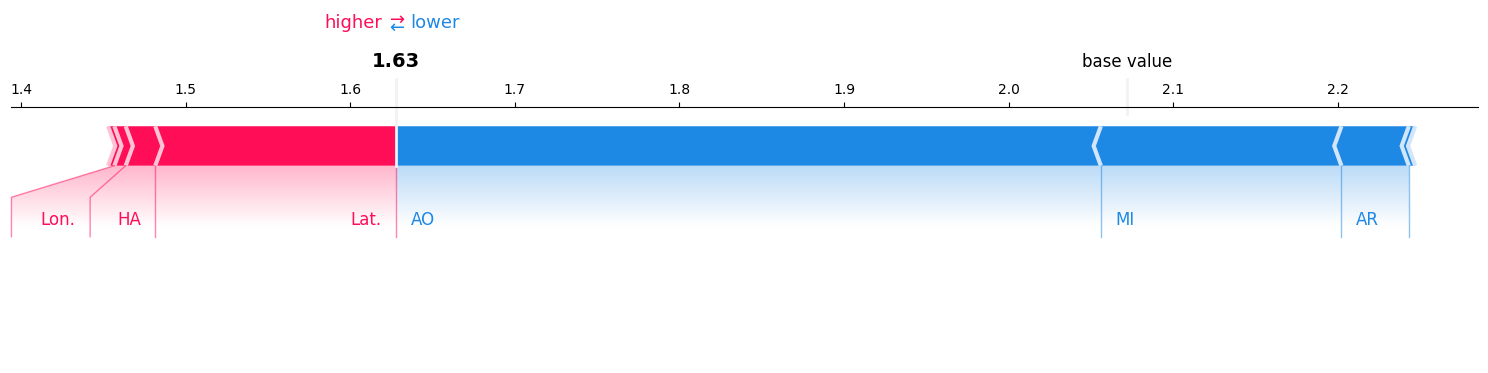

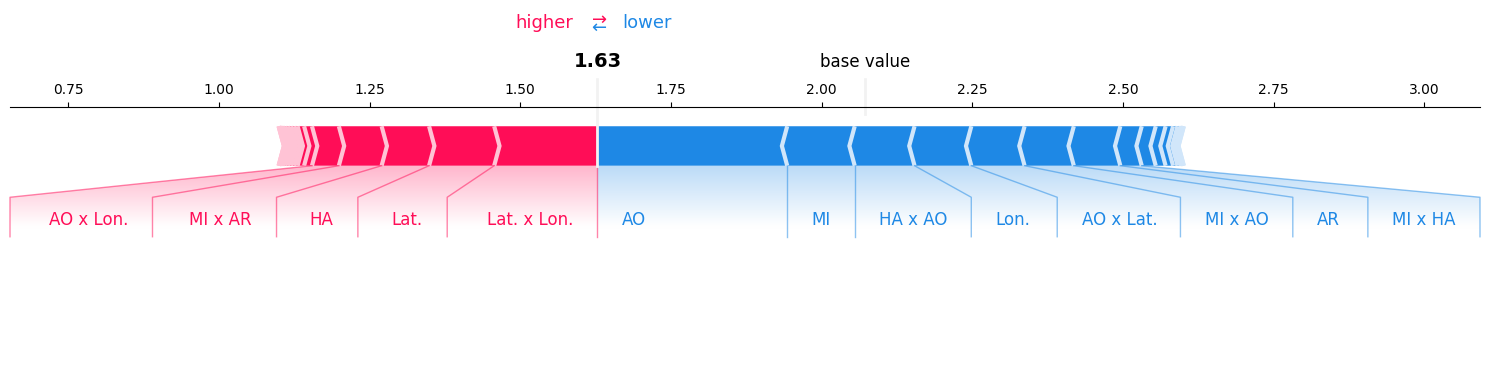

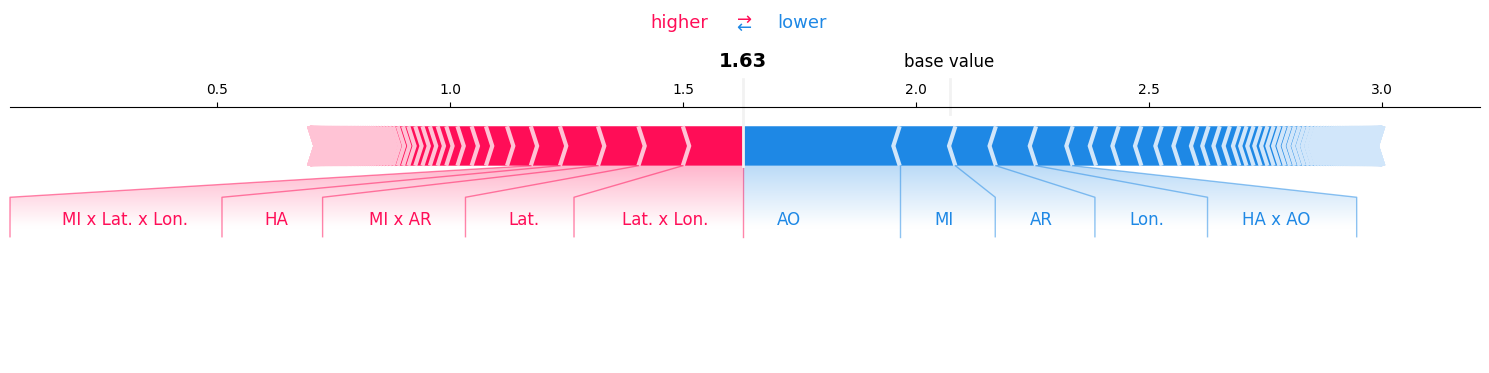

In [5]:
sv = si_order[1]  # get the SV
si = si_order[2]  # get the 2-SII
mi = si_order[n_features]  # get the Moebius transform

sv.plot_force(feature_names=feature_names, show=True)
si.plot_force(feature_names=feature_names, show=True)
mi.plot_force(feature_names=feature_names, show=True)

The first order force plots shows that the prediction is **negatively influenced** by the *AveOccup* (AO), *MedianIncome* (MI), and *AveRooms* (AR) features and **positively influenced** by the *Latitude* (Lat.) and *HouseAge* (HA) features. Ultimately, the prediction is less than the base value of the model (which is about 2.07). The higher-order force plots show also the interactions. This reveals that the exact location of the property, encoded in the interaction between *Latitude* (Lat.) and *Longitude* (Long.), increases the predicted value of the property. Notably, the interaction between the *HouseAge* (HA) and *AvgOccup* (AO) features has a notable negative influence on the prediction.

Notice how for an increasing order, more interaction terms are being displayed. This is to be expected as with an increasing order more interactions are part of each explanation. Formally, the number of interactions scales with $\mathcal{O}\binom{n}{k}$, where $n$ is the number of features and $k$ is the order of the Shapley interactions. Plotting this with force plots can become quite messy quite quickly. This problem is exacerbated when the number of features is large In this example, only 8 features are being considered which typically is not a lot. To solve this other plots can be helpful. For example the waterfall plot.

### Waterfall Plot
Like the force plot, the waterfall plot is also a popular visualization technique for Shapley values.
It, too, was established with `shap`.
Similarly to the force plot, the waterfall plot breaks down the explanation into interactions influencing the prediction positively or negatively.
The benefit for the waterfall plot is the automatic grouping of low-magnitude interactions (interactions with low value) into an *other* group.

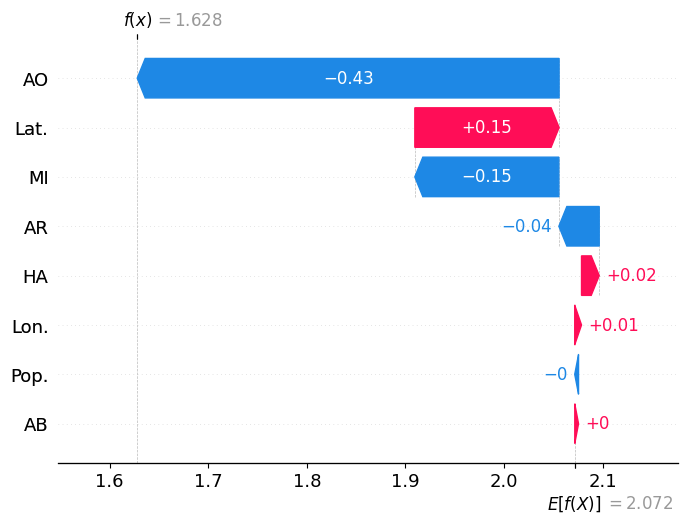

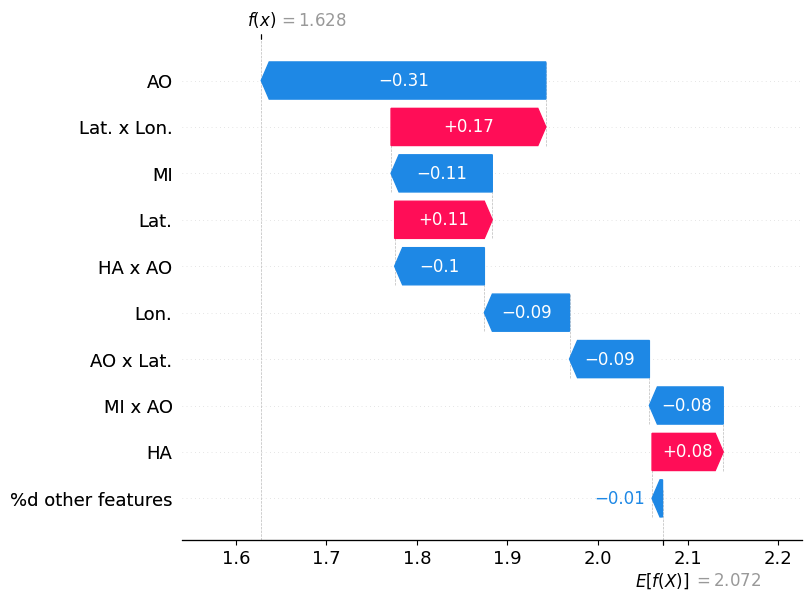

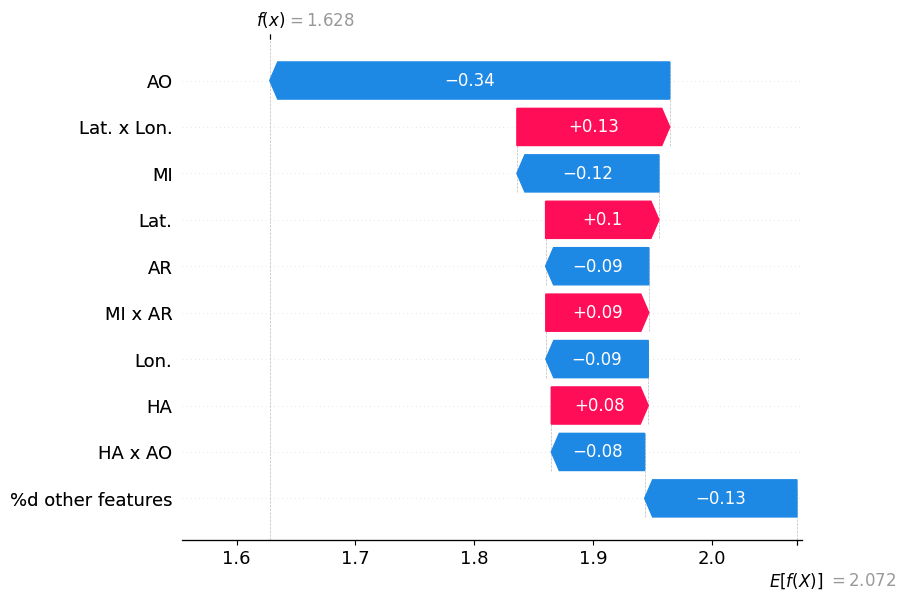

In [6]:
sv.plot_waterfall(feature_names=feature_names, show=True)
si.plot_waterfall(feature_names=feature_names, show=True)
mi.plot_waterfall(feature_names=feature_names, show=True)

With the waterfall plot, similar tendencies can be visualized and interpreted from the Shapley interactions like with the force plot. However, with all remaining features being put into the *other* group, the plot also hides some potentially important insights.

To circumvent this, and to get a more holistic view over the Shapley interactions of potentially high interaction order, we proposed the `network` and `graph` plots.

### Network Plot
The network plot visualizes all first- and second-order interactions of computed Shapley Interactions. While the `network` plot **does not plot higher-order interactions** it does plot all second order interactions. Similar to the color scheme of `shap`, positive interactions are shown in red, negative interactions in blue. The strength of an interaction is encoded in the width of the edge connecting the two features. The strength of a first-order interaction is encoded in the size of the node for the respective feature. For clarity, second-order interactions are also plotted with a decreasing opacity depending on the strength of the interaction.

The following code will plot the network plots for the 2-SII and Moebius transforms. Note that for the Möbius transform, the network plot will only show the first- and second-order interactions (not the higher-order interactions).

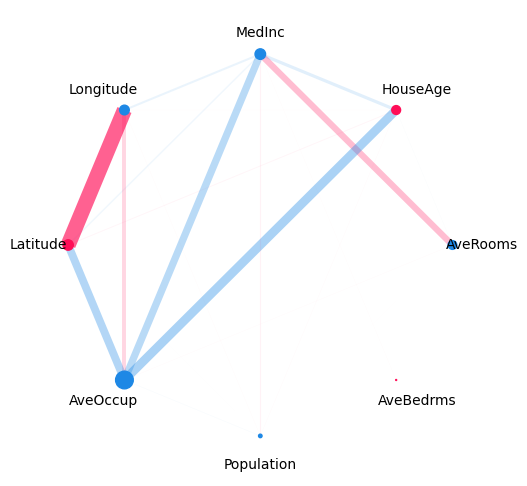

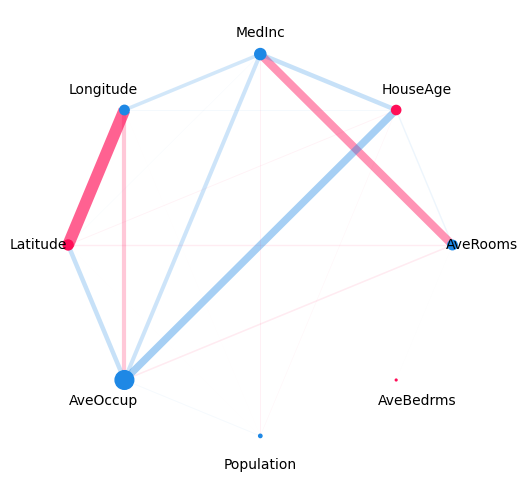

In [7]:
si.plot_network(feature_names=feature_names, show=True, draw_legend=False)
mi.plot_network(feature_names=feature_names, show=True, draw_legend=False)

The network plots show like the force and waterfall plots what features interact with each other and how strong these interactions are. The network plot is particularly useful when the number of features is larger and the force plot does not contain enough information to be interpretable. Here, the network plot for the Möebius transform is slighlty different to the 2-SII plot. So the true functional decomposition of the game (i.e. explanation) is different than the aggregated representation in the second order Shapley interactions. This indicates that interactions higher than second order are important for the explanation of the model's prediction.

### SI Graph Plot
The SI graph plot can be considered the more general version of the network plot in that it can **visualize all higher-order interactions**.
The SI graph plot visualizes all interactions as a graph where the nodes are the features and the edges are the interactions between the features.
Interactions between **more than two features** are visualized as a **hyper-edge**.
Again, the color scheme is the same as for the network plot (red for positive interactions, blue for negative interactions).
The strength of an interaction is encoded in the width of the edge connecting the two features. The strength of a first-order interaction is encoded in the size of the node for the respective feature.
The transparency of the edge/node is used to encode the strength of the interaction/feature attribution.

The following code will plot the SI graph plots for the SV, 2-SII, and Moebius transforms:

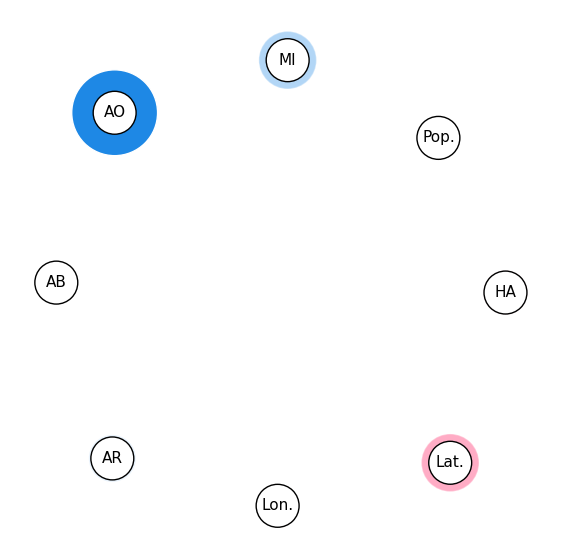

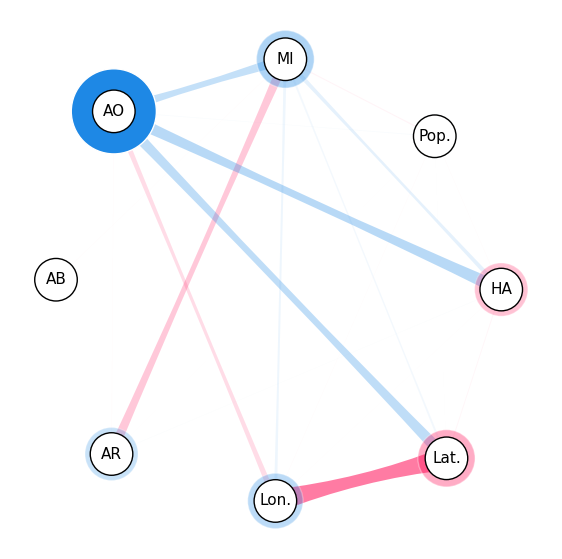

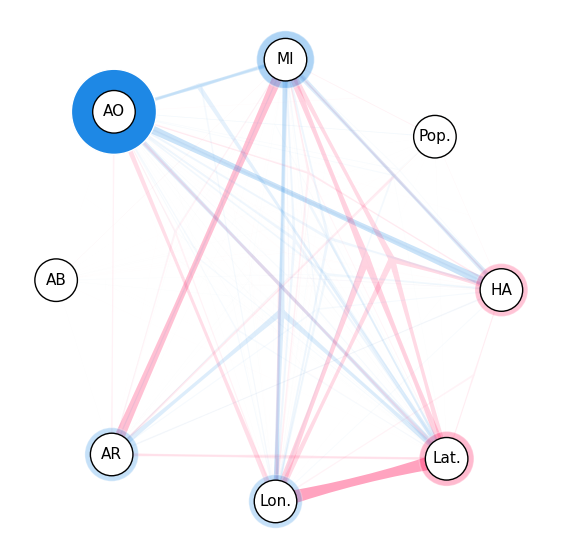

In [8]:
# we abbreviate the feature names since, they are plotted inside the nodes
abbrev_feature_names = shapiq.plot.utils.abbreviate_feature_names(feature_names)
sv.plot_si_graph(
    feature_names=abbrev_feature_names, show=True, size_factor=2.5, node_size_scaling=1.5
)
si.plot_si_graph(
    feature_names=abbrev_feature_names, show=True, size_factor=2.5, node_size_scaling=1.5
)
mi.plot_si_graph(
    feature_names=abbrev_feature_names, show=True, size_factor=2.5, node_size_scaling=1.5
)

**Interpretation of the SI graph plots.**
The first graph plot shows the SV similarly as the force plots and waterfall plots (AveOccup) is the most influential and negative (large blue node size).
The *Latitude* (Lat.) feature is positive (red large-ish node). 
In the 2-SII graph plot, again all interactions are plotted. This representation is the same as the network plot. Only the scaling can be a bit different as sizes are differently computed.
Notably, in the last graph plot for the Möbius transform (the full functional decomposition), all interactions are plotted. 
Next to the first- and second-order interactions hyper-edges connecting various features can be seen.
For example, there is a sizable positive third order interaction between Longitude (Lon.), Latitude (Lat.), and MedianIncome (MI). 
A positive fourth order interaction including the same three features exists with the HouseAge (HA) feature.
In summary, the Möbius graph plot shows how many interactions are necessary to fully explain the model's prediction at this point. 
Still, it remains a challenge to interpret the graph plot in its entirety.


### Bar Plot
While all of the previous plot can theoretically be drawn for global explanations as well, the bar plot is specifically designed for global explanations.
The bar plot from `shap`, shows the mean absolute value of the Shapley values for each feature.
In `shapiq` this is similar in that the bar plot shows the mean absolute value of the Shapley interactions for each interaction of features.

In [9]:
explanations = []
explainer = shapiq.TreeExplainer(model=model, max_order=2, index="k-SII")
for instance_id in tqdm(range(20)):
    x_explain = x_test[instance_id]
    si = explainer.explain(x=x_explain)
    explanations.append(si)

100%|██████████| 20/20 [02:02<00:00,  6.15s/it]


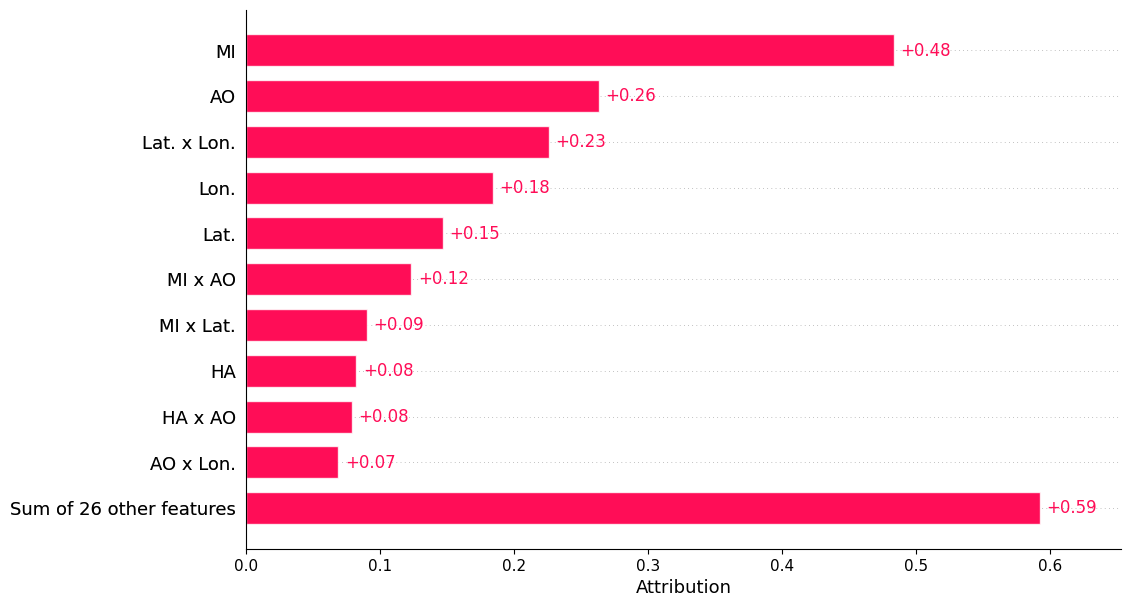

In [10]:
shapiq.plot.bar_plot(explanations, feature_names=feature_names, show=True)